# Multitemporal analysis of Sentinel-1 backscattering during snow melt using high-resolution field measurements and radiative transfer modeling

*DOI to the preprint:* [https://doi.org/10.5194/egusphere-2025-974](https://doi.org/10.5194/egusphere-2025-974)

This code enables the execution of the SMRT simulations and the reproduction of Figure 9 of the paper, where the simulations results are presented.

## SMRT Simulations

The model setup is described in detail in Section 3.2 of the paper. The simulations are based on the high-resolution field measurements available on EnviDat [https://doi.org/10.16904/envidat.574](https://doi.org/10.16904/envidat.574), which the user has to provide. Additionally, the chosen snowpack layering is provided in the *./data* folder. 

In [78]:
# Import SMRT modules
from smrt import make_snowpack, make_model, sensor_list, make_interface
from smrt.substrate.reflector_backscatter import make_reflector
from smrt.emmodel.symsce_torquato21 import derived_SymSCETK21
from smrt.permittivity.snow_mixing_formula import wetsnow_permittivity_memls, permittivity_H86
from smrt.utils import invdB

The following functions are needed to (i) extract data for simulations, (ii) harmonize input snow properties and (iii) correct for small inconsistencies after reaggregation in physical layers.

In [79]:
def extract_roughness(date, df_roughness, param):
    """
    This function extracts the roughness parameters (RMSH and CL) from the measured data, with the following steps:
    1. Check if data is available
    2. If not, the roughness is extracted as an average between the day before and the day after.

    :param date: The date for which the roughness value is being extracted
    :param df_roughness: The dataframe containing the roughness data
    :param param: The roughness parameter
    :return: The extracted roughness value
    """
    if date in df_roughness.index:
        surface_roughness = df_roughness[param].loc[date].mean()
        print(f". Panel data available for {date} ({param.upper()})")
    else:
        # Find the next and previous available dates in the dataset and compute the average 
        previous_available_date = df_roughness.index[df_roughness.index < date].max()
        next_available_date = df_roughness.index[df_roughness.index > date].min()
        next_available_roughness = df_roughness[param].loc[next_available_date].mean()
        previous_available_roughness = df_roughness[param].loc[previous_available_date].mean()
        surface_roughness = (next_available_roughness + previous_available_roughness) / 2
        print(
            f". Panel data unavailable for {date} ({param.upper()}) -- Roughness averaged from previous/next available values")
    return surface_roughness


def extract_local_incidence_angle(date, df_s1_tracks):
    """
    This function extracts the LIA from the S1 tracks to give it as an input to the simulation.
    In the days where we have field measurements but no S1 passings, the LIA is set to the value of the closest
    passage in time
    
    :param date: The date for which the date is being extracted
    :param df_s1_tracks: The dataframe containing the S1 time series
    :return: The LIA
    """
    if pd.Timestamp(date).date() in df_s1_tracks.index.date:
        row = df_s1_tracks.loc[str(pd.Timestamp(date).date())]
        incidence_angles = row.filter(like="lia", axis=1)
        lia = float(incidence_angles[incidence_angles.notnull().any(axis=1)].iloc[0].dropna().values[0])
        print(". LIA for date", date, "extracted and equal to:", lia)
    else:
        # Find the closest S1 passage and extract the LIA from that date
        df_s1_tracks["abs_diff"] = abs(pd.to_datetime(df_s1_tracks.index.date) - pd.to_datetime(date))
        sorted_df_s1_tracks = df_s1_tracks.sort_values(by="abs_diff")
        closest_date = sorted_df_s1_tracks.iloc[0].dropna()
        lia = closest_date.loc[closest_date.index.str.contains("lia")].values[0]
        print(". LIA for date", date, "assigned from the closest date and equal to:", lia)
    return lia


def find_optimal_lag(series1, series2, max_lag=24, direction="positive"):
    """
    This function finds the optimal lag between two time series. It serves to harmonize different measured 
    snow properties. Since measurements were taken next to each other, the horizontal consistency between different 
    snow properties is not always guaranteed.

    :param series1: The first time series
    :param series2: The second time series
    :param max_lag: The maximum lag to test. The default is 24, i.e. 12 cm (approximately 2 * S1 wavelength)
    :param direction: "positive" to find the lag that maximizes the correlation,
                      "negative" to find the lag that minimizes the correlation
    :return: The optimal lag
    """
    # Calculate cross-correlation for each lag from -max_lag to max_lag
    lags = range(-max_lag, max_lag + 1)
    correlations = [series1.corr(series2.shift(lag)) for lag in lags]

    if direction == 'positive':
        # Find the lag that maximizes the correlation
        optimal_lag = lags[np.argmax(correlations)]
    elif direction == 'negative':
        # Find the lag that minimizes the correlation
        optimal_lag = lags[np.argmin(correlations)]
    else:
        raise ValueError("Direction must be either 'positive' or 'negative'.")

    return optimal_lag


def adjust_slightly_negative_temperatures(temperature):
    """
    After reaggregation, some temperature values are only slightly negative (below thermometer sensitivity).
    This function corrects such instances by setting them to isothermal.
    
    :param temperature: The temperature array
    :return: The (corrected) temperature array
    """
    threshold = 0.1
    temperature_celsius = temperature - 273.15
    indices = np.where(abs(temperature_celsius) < threshold)[0]
    temperature[indices] = 273.15
    print(". temperature modified after aggregation")
    return temperature


def adjust_nonphysical_values_aggregated_arrays(temperature, volumetric_liquid_water):
    """
    After reaggregation, some below-zero temperature layers can be associated to positive liquid water content.
    This function corrects such instances.
    
    :param temperature: The temperature array
    :param volumetric_liquid_water: The liquid water content array
    :return: The (corrected) liquid water content array
    """
    for i in range(len(temperature)):
        if (temperature[i] < 273.15 and volumetric_liquid_water[i] > 0):
            volumetric_liquid_water[i] = 0
    print(". volumetric_liquid_water modified after aggregation")
    return volumetric_liquid_water



Constant values are declared:
- The polydispersity k
- The ice density
- The roughness parameters for inner snowpack interfaces: RMSH=1 mm and CL=30 mm (see Section 3.2 of the paper)
- Calibrated soil backscattering for 2023 and 2024
- The different methods used to measure LWC in 2023 (Denothmeter) and 2024 (SLF New Capacitive Sensor)

In [80]:
constants = {
    "k": 0.75,
    "density_of_ice": 917,
    "layer_roughness_rmsh_mm": 1,
    "layer_roughness_cl_mm": 30,
    "soil_scattering_2023": -10.356802042981199,
    "soil_scattering_2024": -9.586760836161803,
    "bias": 3,
    "wetness_method_2023": "denoth",
    "wetness_method_2024": "ncs"
}

The simulations are initialized by declaring:
- The reference cell (see Section 3.1 of the paper)
- The simulation years
- The permittivity formulations (MEMLSv3 and H-86, see Section 3.2 of the paper)
- The estimated variability of the measured LWC (see Section 4.2 of the paper), which will be taken into account in the simulations

In [81]:
reference_cell = 39
years = [2023, 2024]
permittivity_formulations = ["memls", "h86"]
scenarios = ["lwc_minus_one_percent", "lwc_plus_one_percent"]

In [82]:
for year in years:

    # Read data (measured snow profiles, roughness, S1 recorded values, identified physical layers)
    df_profiles = pd.read_csv(f"./data/snowtinel_profiles_{year-1}_{year}.csv", index_col=0, parse_dates=True)
    df_roughness = pd.read_csv(f"./data/snowtinel_surface_roughness_{year}.csv", delimiter=" ", index_col=0, parse_dates=True)
    df_s1_tracks = pd.read_csv(f"./data/s1_cell_{reference_cell}_{year}.csv", index_col=0, parse_dates=True)
    df_physical_layers = pd.read_csv(f"./data/physical_layers.csv", index_col=0, parse_dates=True)

    for permittivity in permittivity_formulations:

        for scenario in scenarios:

            print()
            print("-" * 50)
            print("Year:", year)
            print("Permittivity:", permittivity)
            print("Scenario:", scenario)
            print("-" * 50)
            print()

            # Set empty arrays for inputs, absorption-extinction coefficients and results
            inputs = []
            absorption_extinction = []
            results = []

            # Select unique dates
            dates = df_profiles.index.unique()

            for date in dates:

                print("Reading date:", date)

                # Column selection
                profile = df_profiles.loc[date, ["z", "density_interpolated", f"wetness_{constants[f"wetness_method_{year}"]}_interpolated_corrected", "ssa", "temperature_interpolated"]]
                profile.columns = ["z", "density", "wetness", "ssa", "temperature"]

                # Check for missing data
                if profile.isna().all().any():
                    print(". Missing essential data for modelling on date", date)
                    print()
                    continue

                profile["layer_thickness"] = abs(profile["z"].diff().bfill())

                # Shift time series for best correlation between variables
                lag_ssa = find_optimal_lag(profile['wetness'], profile['ssa'], 24, "negative")
                lag_density = find_optimal_lag(profile['wetness'], profile['density'], 24, "positive")
                profile['ssa_aligned'] = profile['ssa'].shift(lag_ssa)
                profile['density_aligned'] = profile['density'].shift(lag_density)
                profile = profile.ffill().bfill()

                # Extract roughness parameters
                surface_rmsh = extract_roughness(date, df_roughness, "rmsh")
                surface_cl = extract_roughness(date, df_roughness, "cl")
                # Set an upper threshold for roughness to respect the conditions of validity of the IEM
                if surface_rmsh >= 20:
                    surface_rmsh = 20

                # Aggregate properties in physical layers
                layers = [float(x.strip()) for x in df_physical_layers.loc[date]["layering"].split(",")]
                physical_layers_z = np.insert(layers, 0, profile["z"].max())
                bin_edges = np.sort(physical_layers_z)
                profile["bins"] = pd.cut(profile["z"], bins=bin_edges, right=False)
                aggregated_profile = profile.groupby("bins").agg({
                    "wetness": "mean",
                    "density": "mean",
                    "density_aligned": "mean",
                    "temperature": "mean",
                    "ssa": "mean",
                    "ssa_aligned": "mean",
                    "layer_thickness": "sum"
                })
                aggregated_profile = aggregated_profile.dropna()
                aggregated_profile["cumsum_bottom_to_top"] = aggregated_profile["layer_thickness"].iloc[::-1].cumsum().iloc[::-1]

                # Create the snowpack
                thickness = aggregated_profile["layer_thickness"].values * 1e-2
                temperature = aggregated_profile["temperature"].values + 273.15
                density = aggregated_profile["density_aligned"].values
                ssa = aggregated_profile["ssa_aligned"].values
                optical_diameter = 6 / (constants["density_of_ice"] * ssa)
                corr_length = constants["k"] * (2 / 3) * (1 - density / constants["density_of_ice"]) * optical_diameter
                volumetric_liquid_water = aggregated_profile["wetness"].values / 100

                # Adjust volumetric_liquid_water according to the scenario
                if scenario == "lwc_minus_one_percent":
                    volumetric_liquid_water -= 0.01
                    volumetric_liquid_water[volumetric_liquid_water < 0] = 0
                    volumetric_liquid_water[volumetric_liquid_water >= 0.15] = 0.15
                else:
                    volumetric_liquid_water += 0.01
                    volumetric_liquid_water[volumetric_liquid_water < 0] = 0
                    volumetric_liquid_water[volumetric_liquid_water >= 0.15] = 0.15

                # Adjust temperature and volumetric_liquid_water after resampling / scenario selection
                temperature = adjust_slightly_negative_temperatures(temperature)
                volumetric_liquid_water = adjust_nonphysical_values_aggregated_arrays(temperature, volumetric_liquid_water)

                # Create the roughness arrays
                roughness_rmsh = np.array([surface_rmsh] + [constants["layer_roughness_rmsh_mm"]] * (len(thickness) - 1)) / 1000
                roughness_cl = np.array([surface_cl] + [constants["layer_roughness_cl_mm"]] * (len(thickness) - 1)) / 1000

                # Extract or assign the LIA
                lia = extract_local_incidence_angle(date, df_s1_tracks)

                # Define soil scattering
                con_soilVV = invdB(constants[f"soil_scattering_{year}"] + constants["bias"])
                con_soilHH = invdB(constants[f"soil_scattering_{year}"] + constants["bias"])

                # Define the reflector substrate
                substrate = make_reflector(temperature=273.05,
                                           specular_reflection=0,
                                           backscattering_coefficient={"VV": con_soilVV, "HH": con_soilHH})

                # Define the snowpack
                snowpack = make_snowpack(thickness=thickness,
                                         microstructure_model="exponential",
                                         density=density,
                                         temperature=temperature,
                                         corr_length=corr_length,
                                         volumetric_liquid_water=volumetric_liquid_water,
                                         interface=make_interface("iem_fung92_brogioni10", roughness_rms=roughness_rmsh, corr_length=roughness_cl),
                                         substrate=substrate)

                # Define the permittivity formulation
                if permittivity == "memls":
                    model = make_model(derived_SymSCETK21(wetsnow_permittivity_memls), "dort", rtsolver_options=dict(error_handling="nan", diagonalization_method="shur_forcedtriu"))
                else:
                    model = make_model(derived_SymSCETK21(permittivity_H86), "dort", rtsolver_options=dict(error_handling="nan", diagonalization_method="shur_forcedtriu"))

                # Define the sensor (S1)
                sensor = sensor_list.sentinel1(theta=lia)

                # Run the model
                result = model.run(sensor, snowpack)

                # Append inputs
                inputs.append([date, thickness, temperature, density, volumetric_liquid_water, ssa, roughness_rmsh, roughness_cl])
                # Append absorption-extintion coefficients
                absorption_extinction.append([date, thickness, result.other_data["ka"]["layer"].values, result.other_data["ka"].values, result.other_data["ks"].values])
                # Append results
                results.append([date, lia, result.sigmaVV_dB()])

                # Pause not to overload
                time.sleep(0.01)
                print()


            # Convert inputs to DataFrame
            df = pd.DataFrame(inputs)
            df.columns = ["datetime", "thickness", "temperature", "density", "wetness", "ssa", "rmsh", "cl"]
            df = df.set_index("datetime").apply(pd.Series.explode).reset_index()
            df.set_index("datetime", inplace=True)
            df.to_csv(f"./inputs/{year}_input_smrt_{permittivity}_{scenario}.csv")

            # Convert absorption-extinction coefficients to DataFrame
            df = pd.DataFrame(absorption_extinction)
            df.columns = ["datetime", "thickness", "layer", "ka", "ks"]
            df.set_index("datetime", inplace=True)
            df.to_csv(f"./absorption_extinction_coefficients/{year}_coefficients_smrt_{permittivity}_{scenario}.csv")

            # Convert results to DataFrame
            df = pd.DataFrame(results)
            df.columns = ["datetime", "lia", "sigma0"]
            df.set_index("datetime", inplace=True)
            df.to_csv(f"./results/{year}_result_smrt_{permittivity}_{scenario}.csv")



--------------------------------------------------
Year: 2023
Permittivity: memls
Scenario: lwc_minus_one_percent
--------------------------------------------------

Reading date: 2023-02-14 00:00:00
. Panel data available for 2023-02-14 00:00:00 (RMSH)
. Panel data available for 2023-02-14 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-02-14 00:00:00 assigned from the closest date and equal to: 32.833621978759766

Reading date: 2023-02-21 00:00:00
. Panel data available for 2023-02-21 00:00:00 (RMSH)
. Panel data available for 2023-02-21 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-02-21 00:00:00 extracted and equal to: 40.72975540161133

Reading date: 2023-03-01 00:00:00
. Panel data available for 2023-03-01 00:00:00 (RMSH)
. Panel data available for 2023-03-01 00:00:00 (CL)
. temperature modified after aggregation
. volu


Reading date: 2023-05-19 00:00:00
. Panel data available for 2023-05-19 00:00:00 (RMSH)
. Panel data available for 2023-05-19 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-05-19 00:00:00 assigned from the closest date and equal to: 32.844844818115234

Reading date: 2023-05-22 00:00:00
. Panel data unavailable for 2023-05-22 00:00:00 (RMSH) -- Roughness averaged from previous/next available values
. Panel data unavailable for 2023-05-22 00:00:00 (CL) -- Roughness averaged from previous/next available values
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-05-22 00:00:00 assigned from the closest date and equal to: 31.70808219909668

Reading date: 2023-05-24 00:00:00
. Panel data available for 2023-05-24 00:00:00 (RMSH)
. Panel data available for 2023-05-24 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modif


Reading date: 2023-04-12 00:00:00
. Panel data available for 2023-04-12 00:00:00 (RMSH)
. Panel data available for 2023-04-12 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-04-12 00:00:00 assigned from the closest date and equal to: 40.74186325073242

Reading date: 2023-04-19 00:00:00
. Panel data available for 2023-04-19 00:00:00 (RMSH)
. Panel data available for 2023-04-19 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-04-19 00:00:00 assigned from the closest date and equal to: 31.708606719970703

Reading date: 2023-04-24 00:00:00
. Panel data unavailable for 2023-04-24 00:00:00 (RMSH) -- Roughness averaged from previous/next available values
. Panel data unavailable for 2023-04-24 00:00:00 (CL) -- Roughness averaged from previous/next available values
. temperature modified after aggregation
. volumetric_liquid_water modif


Reading date: 2023-06-12 00:00:00
. Panel data available for 2023-06-12 00:00:00 (RMSH)
. Panel data available for 2023-06-12 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-06-12 00:00:00 assigned from the closest date and equal to: 32.828155517578125

Reading date: 2023-06-14 00:00:00
. Panel data available for 2023-06-14 00:00:00 (RMSH)
. Panel data available for 2023-06-14 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-06-14 00:00:00 assigned from the closest date and equal to: 32.828155517578125
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.58932

Reading date: 2023-06-16 00:00:00
. Panel data available for 2023-06-16 00:00:00 (RMSH)
. Panel data available for 2023-06-16 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. L


Reading date: 2023-05-12 00:00:00
. Panel data available for 2023-05-12 00:00:00 (RMSH)
. Panel data available for 2023-05-12 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-05-12 00:00:00 assigned from the closest date and equal to: 31.71571159362793

Reading date: 2023-05-15 00:00:00
. Panel data available for 2023-05-15 00:00:00 (RMSH)
. Panel data available for 2023-05-15 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-05-15 00:00:00 extracted and equal to: 42.03604507446289

Reading date: 2023-05-17 00:00:00
. Panel data available for 2023-05-17 00:00:00 (RMSH)
. Panel data available for 2023-05-17 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-05-17 00:00:00 assigned from the closest date and equal to: 40.74190521240234

Reading date: 2023-05


Reading date: 2023-03-29 00:00:00
. Missing essential data for modelling on date 2023-03-29 00:00:00

Reading date: 2023-04-05 00:00:00
. Panel data available for 2023-04-05 00:00:00 (RMSH)
. Panel data available for 2023-04-05 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-04-05 00:00:00 extracted and equal to: 31.70225715637207

Reading date: 2023-04-10 00:00:00
. Panel data unavailable for 2023-04-10 00:00:00 (RMSH) -- Roughness averaged from previous/next available values
. Panel data unavailable for 2023-04-10 00:00:00 (CL) -- Roughness averaged from previous/next available values
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-04-10 00:00:00 extracted and equal to: 40.74186325073242

Reading date: 2023-04-12 00:00:00
. Panel data available for 2023-04-12 00:00:00 (RMSH)
. Panel data available for 2023-04-12 00:00:00 (CL)
. temperature


Reading date: 2023-06-07 00:00:00
. Panel data available for 2023-06-07 00:00:00 (RMSH)
. Panel data available for 2023-06-07 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-06-07 00:00:00 assigned from the closest date and equal to: 42.04760360717773

Reading date: 2023-06-09 00:00:00
. Panel data available for 2023-06-09 00:00:00 (RMSH)
. Panel data available for 2023-06-09 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-06-09 00:00:00 extracted and equal to: 40.73974609375

Reading date: 2023-06-12 00:00:00
. Panel data available for 2023-06-12 00:00:00 (RMSH)
. Panel data available for 2023-06-12 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-06-12 00:00:00 assigned from the closest date and equal to: 32.828155517578125

Reading date: 2023-06-1


Reading date: 2024-04-11 00:00:00
. Panel data available for 2024-04-11 00:00:00 (RMSH)
. Panel data available for 2024-04-11 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-04-11 00:00:00 extracted and equal to: 31.67867660522461

Reading date: 2024-04-15 00:00:00
. Panel data available for 2024-04-15 00:00:00 (RMSH)
. Panel data available for 2024-04-15 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-04-15 00:00:00 extracted and equal to: 42.05107116699219

Reading date: 2024-04-16 00:00:00
. Panel data unavailable for 2024-04-16 00:00:00 (RMSH) -- Roughness averaged from previous/next available values
. Panel data unavailable for 2024-04-16 00:00:00 (CL) -- Roughness averaged from previous/next available values
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-0

. Panel data available for 2023-12-19 00:00:00 (RMSH)
. Panel data available for 2023-12-19 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-12-19 00:00:00 assigned from the closest date and equal to: 40.73837661743164

Reading date: 2023-12-28 00:00:00
. Panel data available for 2023-12-28 00:00:00 (RMSH)
. Panel data available for 2023-12-28 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2023-12-28 00:00:00 assigned from the closest date and equal to: 42.03570556640625

Reading date: 2024-01-04 00:00:00
. Panel data available for 2024-01-04 00:00:00 (RMSH)
. Panel data available for 2024-01-04 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-01-04 00:00:00 assigned from the closest date and equal to: 32.83352279663086

Reading date: 2024-01-11 00:00:00
.


Reading date: 2024-05-10 00:00:00
. Panel data available for 2024-05-10 00:00:00 (RMSH)
. Panel data available for 2024-05-10 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-05-10 00:00:00 extracted and equal to: 40.73062515258789

Reading date: 2024-05-14 00:00:00
. Panel data available for 2024-05-14 00:00:00 (RMSH)
. Panel data available for 2024-05-14 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-05-14 00:00:00 extracted and equal to: 32.830902099609375

Reading date: 2024-05-17 00:00:00
. Missing essential data for modelling on date 2024-05-17 00:00:00

Reading date: 2024-05-21 00:00:00
. Panel data available for 2024-05-21 00:00:00 (RMSH)
. Panel data available for 2024-05-21 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-05-21 00:00:00 ext


Reading date: 2024-02-15 00:00:00
. Panel data available for 2024-02-15 00:00:00 (RMSH)
. Panel data available for 2024-02-15 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-02-15 00:00:00 extracted and equal to: 42.04121017456055

Reading date: 2024-02-21 00:00:00
. Panel data available for 2024-02-21 00:00:00 (RMSH)
. Panel data available for 2024-02-21 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-02-21 00:00:00 assigned from the closest date and equal to: 32.82969284057617

Reading date: 2024-02-29 00:00:00
. Panel data available for 2024-02-29 00:00:00 (RMSH)
. Panel data available for 2024-02-29 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-02-29 00:00:00 assigned from the closest date and equal to: 40.74653244018555

Reading date: 2024-03


Reading date: 2024-06-14 00:00:00
. Panel data available for 2024-06-14 00:00:00 (RMSH)
. Panel data available for 2024-06-14 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-06-14 00:00:00 extracted and equal to: 42.05290222167969

Reading date: 2024-06-19 00:00:00
. Panel data available for 2024-06-19 00:00:00 (RMSH)
. Panel data available for 2024-06-19 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-06-19 00:00:00 extracted and equal to: 32.83340072631836

Reading date: 2024-06-22 00:00:00
. Panel data available for 2024-06-22 00:00:00 (RMSH)
. Panel data available for 2024-06-22 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-06-22 00:00:00 extracted and equal to: 31.685800552368164

Reading date: 2024-06-26 00:00:00
. Panel data unavailable for


Reading date: 2024-04-08 00:00:00
. Panel data available for 2024-04-08 00:00:00 (RMSH)
. Panel data available for 2024-04-08 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-04-08 00:00:00 extracted and equal to: 32.8471565246582

Reading date: 2024-04-11 00:00:00
. Panel data available for 2024-04-11 00:00:00 (RMSH)
. Panel data available for 2024-04-11 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-04-11 00:00:00 extracted and equal to: 31.67867660522461

Reading date: 2024-04-15 00:00:00
. Panel data available for 2024-04-15 00:00:00 (RMSH)
. Panel data available for 2024-04-15 00:00:00 (CL)
. temperature modified after aggregation
. volumetric_liquid_water modified after aggregation
. LIA for date 2024-04-15 00:00:00 extracted and equal to: 42.05107116699219

Reading date: 2024-04-16 00:00:00
. Panel data unavailable for 2

## Simulation results compared to the recorded S1 time series

The following functions are needed to read the simulation results and plot them together with the recorded S1 time series.

In [91]:
def get_melting_phases_dates(year):
    """
    This function returns the phase start dates based on the year, as suggested by Marin et al., 2020.
    """
    if year == 2023:
        return pd.to_datetime("2023-04-19"), pd.to_datetime("2023-04-26")
    else:
        return pd.to_datetime("2024-04-04"), pd.to_datetime("2024-04-15")


def get_sigma_dry(df_s1, reference_cell, year):
    """
    This function computes sigma_dry for the winter period based on the provided reference cell.
    """
    meteo_winter_start = pd.to_datetime(f"{year - 1}-12-01").date()
    meteo_winter_end = pd.to_datetime(f"{year}-02-28").date()

    sigma_cols = [f"sigma0_{reference_cell}_15_{year - 1}", f"sigma0_{reference_cell}_66_{year - 1}",
                  f"sigma0_{reference_cell}_168_{year - 1}", f"sigma0_{reference_cell}_117_{year - 1}"]
    return df_s1[sigma_cols].loc[meteo_winter_start:meteo_winter_end].mean().mean()


def get_runoff_start(df_melting_phases):
    """
    This function calculates the runoff start as suggested by Marin et al., 2020.
    """
    morning_runoff_start = df_melting_phases["morning_descending_sigma0"].loc[
        df_melting_phases["morning_descending_sigma0"] <= df_melting_phases["morning_descending_sigma0"].min()].index[0]
    afternoon_runoff_start = df_melting_phases["afternoon_ascending_sigma0"].loc[
        df_melting_phases["afternoon_ascending_sigma0"] <= df_melting_phases["afternoon_ascending_sigma0"].min()].index[0]
    return morning_runoff_start + (afternoon_runoff_start - morning_runoff_start) / 2


def assign_phases_to_df(df_melting_phases, moistening_start, ripening_start, runoff_start):
    """
    This function assigns melting phases to df_melting_phases based on date ranges.
    """
    df_melting_phases.loc[df_melting_phases.index < moistening_start, "melting_phase"] = "Dry"
    df_melting_phases.loc[(df_melting_phases.index >= moistening_start) & (df_melting_phases.index < ripening_start), "melting_phase"] = "Moistening"
    df_melting_phases.loc[df_melting_phases.index >= ripening_start, "melting_phase"] = "Ripening"
    df_melting_phases.loc[df_melting_phases.index >= runoff_start, "melting_phase"] = "Runoff"


def identify_melting_phases(df_s1, df_melting_phases, year, reference_cell, threshold=-2):
    """
    This function identifies the melting phases as suggested by Marin et al., 2020.
    """
    # Compute sigma_dry for the winter period
    sigma_dry = get_sigma_dry(df_s1, reference_cell, year)
    # Define dry period end
    dry_period_end = df_melting_phases["afternoon_ascending_sigma0"].loc[
        df_melting_phases["afternoon_ascending_sigma0"] - sigma_dry <= threshold].index[0]
    # Get melting phase start dates
    moistening_start, ripening_start = get_melting_phases_dates(year)
    # Calculate runoff start date
    runoff_start = get_runoff_start(df_melting_phases)
    # Assign melting phases to df_melting_phases
    assign_phases_to_df(df_melting_phases, moistening_start, ripening_start, runoff_start)
    return df_melting_phases, moistening_start, ripening_start, runoff_start


def load_and_process_data(year, scenarios, reference_cell):
    """
    This function loads and processes SMRT simulation results and S1 recordings for each year and scenario.
    """
    smrt_output_memls = pd.DataFrame()
    smrt_output_h86 = pd.DataFrame()
    df_s1_tracks = pd.read_csv(
        f"/home/carletti/Projects/SnowTinel/Paper_1/github/data/s1_cell_{reference_cell}_{year}.csv", index_col=0,
        parse_dates=True)

    # Process each scenario for smrt_output_memls and smrt_output_h86
    for scenario in scenarios:
        memls_file = f"/home/carletti/Projects/SnowTinel/Paper_1/github/results/{year}_result_smrt_memls_{scenario}.csv"
        h86_file = f"/home/carletti/Projects/SnowTinel/Paper_1/github/results/{year}_result_smrt_h86_{scenario}.csv"

        df_tmp_memls = pd.read_csv(memls_file, index_col=0, parse_dates=True)
        df_tmp_h86 = pd.read_csv(h86_file, index_col=0, parse_dates=True)

        smrt_output_memls[f"sigma0_{scenario}"] = df_tmp_memls["sigma0"]
        smrt_output_h86[f"sigma0_{scenario}"] = df_tmp_h86["sigma0"]

    # Reindex df_s1_tracks to full date range
    df_s1_tracks.index = pd.to_datetime(df_s1_tracks.index).date
    full_date_range = pd.date_range(start=df_s1_tracks.first_valid_index(), end=df_s1_tracks.last_valid_index(),
                                    freq='D')
    df_s1_tracks = df_s1_tracks.reindex(full_date_range)

    # Interpolate missing values for tracks (for easier plotting)
    for track in [15, 66, 117, 168]:
        source_column = f"sigma0_{reference_cell}_{track}_{year - 1}"
        if source_column in df_s1_tracks:
            df_s1_tracks[f"sigma0_{track}"] = df_s1_tracks[source_column].interpolate(method='linear').ffill().bfill()

    return smrt_output_memls, smrt_output_h86, df_s1_tracks


def plot_melting_phases(ax12, df_melting_phases, moistening_start, ripening_start, runoff_start):
    """
    This function plots vertical lines and labels indicating the melting phases.
    """
    start_dates = [df_melting_phases.first_valid_index(), moistening_start, ripening_start, runoff_start]
    end_dates = [moistening_start, ripening_start, runoff_start, df_melting_phases.last_valid_index()]
    phase_names = ["Dry", "Moistening", "Ripening", "Runoff"]

    for i, j, phase_name in zip(start_dates, end_dates, phase_names):
        start_date = pd.to_datetime(i)
        end_date = pd.to_datetime(j)
        start_value = mdates.date2num(start_date)
        end_value = mdates.date2num(end_date)
        ax12.axvline(j, color="grey", ls="--", lw=1)
        midpoint_value = (start_value + end_value) / 2
        ax12.text(midpoint_value, 0.95, phase_name, transform=ax12.get_xaxis_transform(),
                  ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


def plot_fill_between(ax12, df_s1_tracks, colors_s1):
    """
    This function plots the range between each pair of morning and afternoon S1 acquisitions.
    """
    l1 = ax12.fill_between(df_s1_tracks.index, df_s1_tracks["sigma0_66"].dropna(), df_s1_tracks["sigma0_168"].dropna(),
                           alpha=0.25,
                           color=colors_s1[6], label="S1 range (tracks 066, 168), descending, 05:30")
    l2 = ax12.fill_between(df_s1_tracks.index, df_s1_tracks["sigma0_15"].dropna(), df_s1_tracks["sigma0_117"].dropna(),
                           alpha=0.25,
                           color=colors_s1[2], label="S1 range (tracks 015, 117), ascending, 17:30")
    return l1, l2


def plot_boxplots(ax12, smrt_output_memls, smrt_output_h86):
    """
    This function plots boxplots to show sensitivity to LWC variability according to the two considered 
    permittivity formulations, MEMLSv3 and H-86.
    """
    # Declare an offset for better plot readability and line widths for boxplots
    offset = 0.2
    lw = 1
    # MEMLSv3
    smrt_output_boxplot = smrt_output_memls.T.copy()
    positions = mdates.date2num(smrt_output_boxplot.columns) - offset
    smrt_output_boxplot.boxplot(
        positions=positions, widths=0.5, patch_artist=True, ax=ax12,
        boxprops=dict(linewidth=lw, color="black", facecolor="dimgray"),
        whiskerprops=dict(linewidth=lw, color="black"),
        capprops=dict(linewidth=lw, color="black"),
        medianprops=dict(linewidth=lw, color="black"),
        meanline=False, flierprops=dict(markeredgewidth=lw, markerfacecolor="white", markeredgecolor="black")
    )
    # H-86 
    smrt_output_boxplot = smrt_output_h86.T.copy()
    positions = mdates.date2num(smrt_output_boxplot.columns) + offset
    smrt_output_boxplot.boxplot(
        positions=positions, widths=0.5, patch_artist=True, ax=ax12,
        boxprops=dict(linewidth=lw, color="black", facecolor="gainsboro"),
        whiskerprops=dict(linewidth=lw, color="black"),
        capprops=dict(linewidth=lw, color="black"),
        medianprops=dict(linewidth=lw, color="black"),
        meanline=False, flierprops=dict(markeredgewidth=lw, markerfacecolor="white", markeredgecolor="black")
    )


def plot_s1_values(ax12, df_s1_tracks, smrt_output_memls, colors_s1):
    """
    This function plots the exact values of S1 acquisitions 
    (only when the passages coincide with field measurements).
    """
    df_s1_field_morning = df_s1_tracks.filter(like="morning_descending", axis=1)
    df_s1_field_afternoon = df_s1_tracks.filter(like="afternoon_ascending", axis=1)

    df_s1_field_morning.index = pd.to_datetime(df_s1_field_morning.index)
    common_dates_morning = smrt_output_memls.index.intersection(df_s1_field_morning.index)
    df_s1_filtered_morning = df_s1_field_morning.loc[common_dates_morning]

    df_s1_field_afternoon.index = pd.to_datetime(df_s1_field_afternoon.index)
    common_dates_afternoon = smrt_output_memls.index.intersection(df_s1_field_afternoon.index)
    df_s1_filtered_afternoon = df_s1_field_afternoon.loc[common_dates_afternoon]

    l3, = ax12.plot(df_s1_filtered_morning["morning_descending_sigma0"].dropna().index,
                    df_s1_filtered_morning["morning_descending_sigma0"].dropna(), "v", markersize=8,
                    color=colors_s1[6],
                    mec="k", label="S1 simultaneous recordings")
    l4, = ax12.plot(df_s1_filtered_afternoon["afternoon_ascending_sigma0"].dropna().index,
                    df_s1_filtered_afternoon["afternoon_ascending_sigma0"].dropna(), "^", markersize=8,
                    color=colors_s1[2], mec="k", label="S1 simultaneous recordings")
    return l3, l4


def filter_data_by_month(df, start_month=4, start_day=1, end_month=7, end_day=15):
    """
    This function filters the dataframe to only include data from April 1st to July 15th for better plot readability.
    """
    df.index = pd.to_datetime(df.index)    
    filtered_df = df[(df.index.month >= start_month) & 
                     ((df.index.month < end_month) | 
                      (df.index.month == start_month) & (df.index.day >= start_day) | 
                      (df.index.month == end_month) & (df.index.day <= end_day))]
    
    return filtered_df


def adjust_ticks(index, ax, fontsize=10):
    """
    This function simply adjusts the style of the x-ticks for better plot readability
    """
    # Declare the tick labels
    tick_labels = np.array(index)
    # Convert tick labels to datetime objects
    dates = pd.to_datetime(tick_labels)
    # Initialize tick positions and labels
    tick_positions = []
    formatted_labels = []
    prev_date = None

    for date in dates:
        day = date.strftime("%-d")  # Remove leading zeros from days
        month = date.strftime("%b")
        year = date.strftime("%Y")

        if prev_date is None or (date - prev_date).days > 1:
            # First date or not consecutive, include appropriate label
            if prev_date is None or date.month != prev_date.month:
                # First date or new month starts, include the year
                label = f"{day}\n{month}\n{year}"
            elif date.month != prev_date.month:
                # New month starts, include the month
                label = f"{day}\n{month}"
            else:
                # Same month, show only the day
                label = day
        else:
            # Consecutive date, add an empty label
            label = ""

        # Append to tick positions and labels
        tick_positions.append(date)
        formatted_labels.append(label)

        # Update previous date
        prev_date = date

    # Set custom tick positions and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(formatted_labels, fontsize=fontsize)

    # Set custom rotation and alignment for the x-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        tick.set_horizontalalignment("center")

    return


def plot_figure_9():
    """
    This function generates the plot of Fig. 9 of the paper (without the annotations).
    """
    years = [2023, 2024]
    scenarios = ["lwc_minus_one_percent", "lwc_plus_one_percent"]
    labels = ["(a)", "(b)"]
    reference_cell = 39
    colors_s1 = cm.roma(np.linspace(0, 1, 11)) # Colorblind safe palette

    fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharey=True, figsize=(15, 8))

    for year, ax12, label in zip(years, [ax1, ax2], labels):
        # Load and process data
        smrt_output_memls, smrt_output_h86, df_s1_tracks = load_and_process_data(year, scenarios, reference_cell)

        # Identify melting phases
        df_melting_phases = df_s1_tracks[["morning_descending_sigma0", "afternoon_ascending_sigma0"]]
        df_melting_phases.index = pd.to_datetime(df_melting_phases.index)
        df_melting_phases = df_melting_phases.loc[
                            smrt_output_memls.first_valid_index():smrt_output_memls.last_valid_index()]
        df_melting_phases["melting_phase"] = ["null"] * len(df_melting_phases)
        df_melting_phases, moistening_start, ripening_start, runoff_start = identify_melting_phases(
            df_s1_tracks, df_melting_phases, year, reference_cell, threshold=-2)
        
        # Despite the threshold to the RMSH range imposed in the simulation, the last 2 simulation days of 2023
        # exceed the limits of validity of the IEM, therefore they are discarded
        if year == 2023:
            smrt_output_memls = smrt_output_memls[:-2]
            smrt_output_h86 = smrt_output_h86[:-2]
        
        # Filter all time series to be plotted from April to July, to focus on wet snow only for better plot
        # readability. To check results for different time spans, start_month, start_day and end_month, end_day
        # can be changed.
        if year == 2023:
            start_month = 4
            start_day = 1
            end_month = 6
            end_day = 12
        else:
            start_month = 3
            start_day = 1
            end_month = 7
            end_day = 4
        dataframes = [df_melting_phases, df_s1_tracks, smrt_output_memls, smrt_output_h86]
        filtered_dataframes = [filter_data_by_month(df, start_month=start_month, start_day=start_day, 
                                end_month=end_month, end_day=end_day) for df in dataframes]
        df_melting_phases, df_s1_tracks, smrt_output_memls, smrt_output_h86 = filtered_dataframes

        # Plot melting phases
        plot_melting_phases(ax12, df_melting_phases, moistening_start, ripening_start, runoff_start)

        # Plot fill between
        l1, l2 = plot_fill_between(ax12, df_s1_tracks, colors_s1)

        # Plot boxplots for MEMLSv3 and H-86
        plot_boxplots(ax12, smrt_output_memls, smrt_output_h86)

        # Plot field data (points)
        l3, l4 = plot_s1_values(ax12, df_s1_tracks, smrt_output_memls, colors_s1)

        # Add labels and customize legend
        ax1.set_ylabel(r"$\sigma_0^{VV}$ [dB]")
        ax2.set_ylabel(r"$\sigma_0^{VV}$ [dB]")

        boxplot_patch_memls = matplotlib.patches.Patch(edgecolor="k", facecolor="dimgray",
                                                       label="Modelled $\sigma_0$ variability to ±1% LWC (MEMLSv3)")
        boxplot_patch_h86 = matplotlib.patches.Patch(edgecolor="k", facecolor="gainsboro",
                                                     label="Modelled $\sigma_0$ variability to ±1% LWC (H-86)")

        handles = [l1, l2, (l3, l4), boxplot_patch_memls, boxplot_patch_h86]
        labels = ["S1 range (tracks 066, 168), descending, 05:30", "S1 range (tracks 015, 117), ascending, 17:30",
                  "S1 simultaneous acquisitions", "Modelled $\sigma_0^{VV}$ variability to ±1% LWC (MEMLSv3)",
                  "Modelled $\sigma_0^{VV}$ variability to ±1% LWC (H-86)"]
        ax12.legend(handles=handles, labels=labels, loc="lower right",
                    handler_map={tuple: matplotlib.legend_handler.HandlerTuple(None)}, handletextpad=1,
                    labelspacing=0.5, prop={"size": 7})

        ax12.grid(ls="")
        adjust_ticks(smrt_output_memls.index, ax12, fontsize=10)
        ax12.text(0.01, 0.97, label, transform=ax12.transAxes, va="top", ha="left", fontsize=14, color="k")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.08, hspace=0.6)
    
    # Save figure in .pdf format
    plt.savefig("./fig9.pdf")
    
    plt.show()
    

Figure 9 is reproduced and saved in .pdf format.

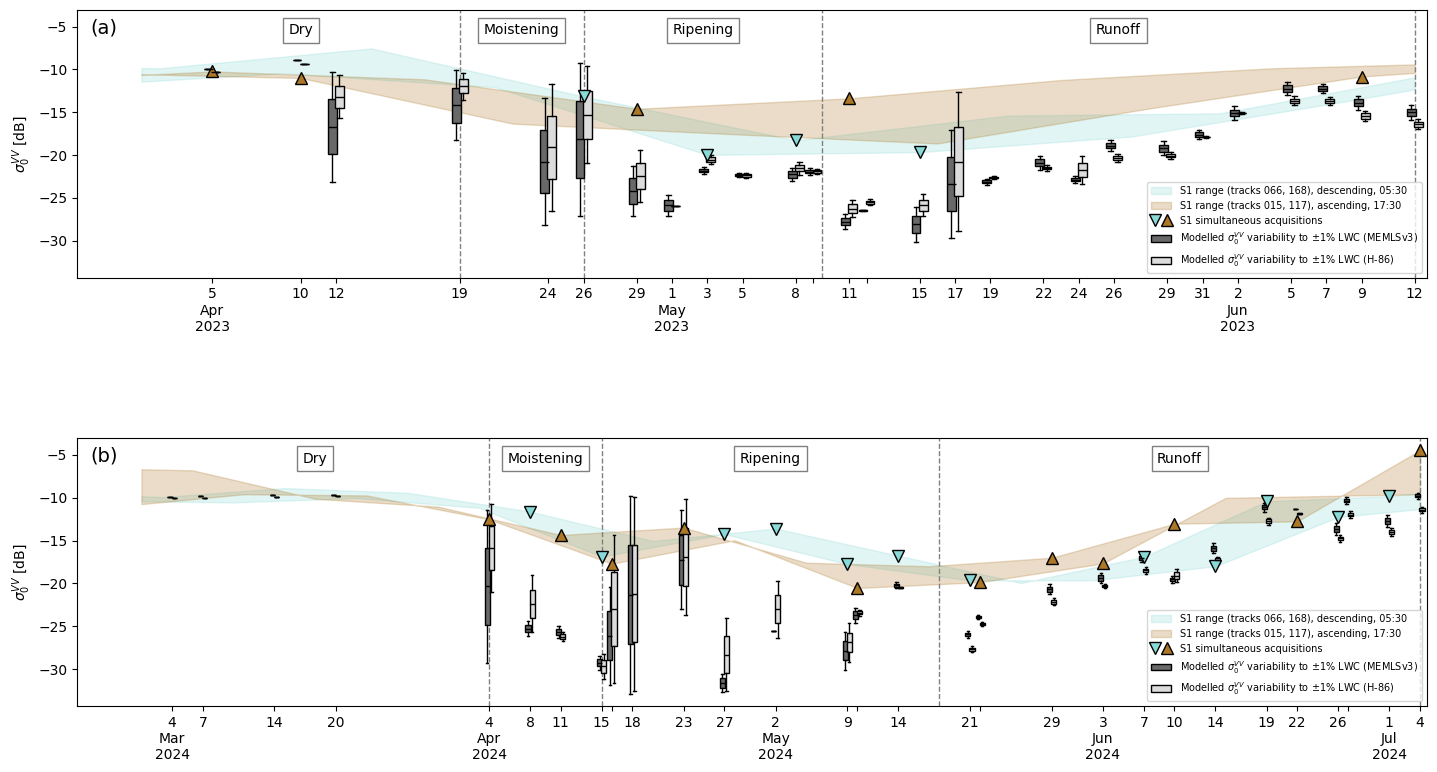

In [92]:
plot_figure_9()